In [4]:
!pip install tensorflow==2.10

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Define your data directories
train_data_directory = "/kaggle/input/mrl-eye-dataset/data/train"
test_data_directory = "/kaggle/input/mrl-eye-dataset/data/test"

# Set the image size and batch size
img_size = (30, 30)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Assuming 80% training and 20% validation
    rotation_range=20,  # Additional augmentation for diversity
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Generate the training dataset
train_generator = datagen.flow_from_directory(
    train_data_directory,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',  # 'binary' for binary classification
    subset='training'  # Use 'training' for training dataset
)

# Generate the validation dataset
validation_generator = datagen.flow_from_directory(
    train_data_directory,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Generate the test dataset
test_generator = datagen.flow_from_directory(
    test_data_directory,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False  # Set to False to maintain the order for evaluation
)



Found 65340 images belonging to 2 classes.
Found 16335 images belonging to 2 classes.
Found 3223 images belonging to 2 classes.


In [6]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
# Build your CNN model using TensorFlow's Keras API
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1, activation='sigmoid')
])


In [7]:
from tensorflow.keras.optimizers import Adam
loss = 'binary_crossentropy'
metrics = ['accuracy']
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [8]:
# Define a ModelCheckpoint callback to save the model on each batch
checkpoint_callback = ModelCheckpoint(
    "eye_blink.h5",  # Specify the path to save the model
    save_freq='epoch',  # Save on each batch
    save_best_only=True,  # Save every model
    save_weights_only=False,  # Save the entire model
    verbose=1
)
# Train your model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_callback]
)

# Evaluate your model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/20
2041/2041 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.8364
Epoch 1: val_loss improved from inf to 0.24303, saving model to eye_blink.h5
2041/2041 [==============================] - 591s 289ms/step - loss: 0.3441 - accuracy: 0.8364 - val_loss: 0.2430 - val_accuracy: 0.9119
Epoch 2/20
2040/2041 [============================>.] - ETA: 0s - loss: 0.1677 - accuracy: 0.9349
Epoch 2: val_loss improved from 0.24303 to 0.20303, saving model to eye_blink.h5
2041/2041 [==============================] - 153s 75ms/step - loss: 0.1677 - accuracy: 0.9349 - val_loss: 0.2030 - val_accuracy: 0.9171
Epoch 3/20
2041/2041 [==============================] - ETA: 0s - loss: 0.1444 - accuracy: 0.9444
Epoch 3: val_loss improved from 0.20303 to 0.17332, saving model to eye_blink.h5
2041/2041 [==============================] - 146s 72ms/step - loss: 0.1444 - accuracy: 0.9444 - val_loss: 0.1733 - val_accuracy: 0.9297
Epoch 4/20
2041/2041 [==============================] - ET

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Assuming y_true, y_pred_probs, and test_generator are defined
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs >= 0.5).astype(int)

# Compute and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

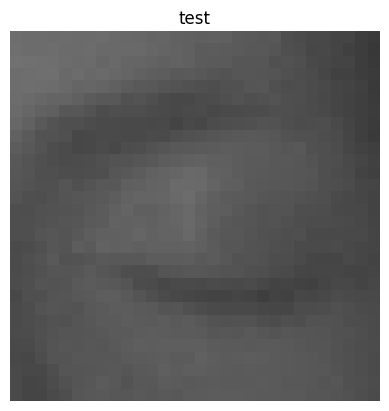

1/1 [==============================] - 0s 130ms/step
[[1.1706733e-06]]
eye close detected.


In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess an input image
def preprocess_image(image_path, target_size=(30, 30), grayscale=True):
    # Read the image
    image = cv2.imread(image_path)

    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    if grayscale:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Convert to float32 and normalize to the range [0, 1]
    image = image.astype(np.float32) / 255.0

    return image
# Load the model
model = load_model('eye_blink.h5')
# Load an example image
example_image_path = '/kaggle/input/mrl-eye-dataset/data/test/close eyes/s0002_00001_0_0_0_0_0_01.png'
#example_image_path = '/kaggle/input/mrl-eye-dataset/data/test/open eyes/s0001_01846_0_0_1_0_0_01.png'

def cv2_imshow(image, title="Image"):
    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display using matplotlib
    plt.imshow(image_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()
    


input_image = preprocess_image(example_image_path, grayscale=True)
cv2_imshow(input_image, "test")
# Expand dimensions to match the model input shape
input_image = np.expand_dims(input_image, axis=0)

# Make a prediction
prediction = model.predict(input_image)

print(prediction)

# Convert the prediction to a binary result (blink or not)
is_eye_open = prediction[0, 0] > 0.5

# Print the result
if is_eye_open:
    print("eye open detected!")
else:
    print("eye close detected.")